In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Module, ModuleList, Sequential
import torch_geometric
from torch_geometric.nn import EdgeConv, DenseGCNConv, DenseGraphConv, GCNConv, GATConv
from torch.utils.data import DataLoader
import torch_scatter
from torch_geometric.data import Data

import numpy as np
import os

## Layers

In [2]:
def layer(layer_type, **kwargs):
    if layer_type == 'GCNConv':
        return GraphConvolution(in_features=kwargs['in_channels'], out_features=kwargs['out_channels'])
    elif layer_type == 'GATConv':
        return MultiHeadAttentionLayer(in_features=kwargs['in_channels'], out_features=kwargs['out_channels'],
                                       heads=kwargs['heads'], concat=kwargs['concat'])

In [3]:
class GraphConvolution(torch.nn.Module):

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

In [4]:
class GraphAttentionLayer(nn.Module):
    """
    Simple GAT layer, similar to https://arxiv.org/abs/1710.10903
    """

    def __init__(self, in_features, out_features, dropout=0.6, alpha=0.2, concat=True):
        super(GraphAttentionLayer, self).__init__()
        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat

        self.W = nn.Parameter(torch.empty(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a = nn.Parameter(torch.empty(size=(2 * out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, h, adj):
        Wh = torch.mm(h, self.W)  # h.shape: (N, in_features), Wh.shape: (N, out_features)
        e = self._prepare_attentional_mechanism_input(Wh)

        zero_vec = -9e15 * torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime = torch.matmul(attention, Wh)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

    def _prepare_attentional_mechanism_input(self, Wh):
        # Wh.shape (N, out_feature)
        # self.a.shape (2 * out_feature, 1)
        # Wh1&2.shape (N, 1)
        # e.shape (N, N)
        Wh1 = torch.matmul(Wh, self.a[:self.out_features, :])
        Wh2 = torch.matmul(Wh, self.a[self.out_features:, :])
        # broadcast add
        e = Wh1 + Wh2.T
        return self.leakyrelu(e)

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'

In [5]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, in_features, out_features, heads, concat=True):
        super(MultiHeadAttentionLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.attentions = [GraphAttentionLayer(in_features, out_features, concat=concat) for _ in range(heads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)

    def forward(self, x, adj):
        x = torch.cat([torch.unsqueeze(att(x, adj), 0) for att in self.attentions])
        x = torch.mean(x, dim=0)
        return x

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'


## Model

In [6]:
class GNNImpute(torch.nn.Module):
    def __init__(self, input_dim, h_dim=512, z_dim=50, layerType='GATConv', heads=3):
        super(GNNImpute, self).__init__()

        #### Encoder ####
        self.encode_conv1 = layer(layerType, in_channels=input_dim, out_channels=h_dim,
                                  heads=heads, concat=False)
        self.encode_bn1 = torch.nn.BatchNorm1d(h_dim)

        self.encode_conv2 = layer(layerType, in_channels=h_dim, out_channels=z_dim,
                                  heads=heads, concat=False)
        self.encode_bn2 = torch.nn.BatchNorm1d(z_dim)

        #### Decoder ####
        self.decode_linear1 = torch.nn.Linear(z_dim, h_dim)
        self.decode_bn1 = torch.nn.BatchNorm1d(h_dim)

        self.decode_linear2 = torch.nn.Linear(h_dim, input_dim)

    def encode(self, x, edge_index):
        x = F.relu(self.encode_bn1(self.encode_conv1(x, edge_index)))
        x = F.dropout(x, p=0.5, training=self.training)

        x = F.relu(self.encode_bn2(self.encode_conv2(x, edge_index)))
        x = F.dropout(x, p=0.5, training=self.training)

        return x

    def decode(self, x):
        x = F.relu(self.decode_bn1(self.decode_linear1(x)))
        x = F.relu(self.decode_linear2(x))

        return x

    def forward(self, x, edge_index, size_factors):
        z = self.encode(x, edge_index)
        x = self.decode(z)
        #x = x * size_factors
        return x

## Utils

In [7]:
import numpy as np
import scanpy as sc
import scipy.sparse as sp

from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph

In [8]:
def normalize(adata, filter_min_counts=True, size_factors=True, normalize_input=True, logtrans_input=True):
    if filter_min_counts:
        sc.pp.filter_genes(adata, min_counts=1)
        sc.pp.filter_cells(adata, min_counts=1)

    # if size_factors or normalize_input or logtrans_input:
    #     adata.raw = adata.copy()
    # else:
    #     adata.raw = adata

    if size_factors:
        sc.pp.normalize_per_cell(adata)
        adata.obs['size_factors'] = adata.obs.n_counts / np.median(adata.obs.n_counts)
    else:
        adata.obs['size_factors'] = 1.0

    if logtrans_input:
        sc.pp.log1p(adata)

    if normalize_input:
        sc.pp.scale(adata)

    return adata

In [14]:
def train_val_split(adata, seed=321, train_size=0.8, val_size=0.1, test_size=0.1):
    assert train_size + val_size + test_size == 1

    adata = adata.copy()
    np.random.seed(seed)

    cell_nums = adata.n_obs
    test_val = np.random.choice(cell_nums, int(cell_nums * (val_size + test_size)), replace=False)
    idx_train = [i for i in list(range(cell_nums)) if i not in test_val]
    idx_test = np.random.choice(test_val, int(len(test_val) * (test_size / (val_size + test_size))), replace=False)
    idx_val = [i for i in test_val if i not in idx_test]

    tmp = np.zeros(cell_nums, dtype=bool)
    tmp[idx_train] = True
    adata.obs['idx_train'] = tmp
    tmp = np.zeros(cell_nums, dtype=bool)
    tmp[idx_val] = True
    adata.obs['idx_val'] = tmp
    tmp = np.zeros(cell_nums, dtype=bool)
    tmp[idx_test] = True
    adata.obs['idx_test'] = tmp

    return adata

In [15]:
def row_normalize(mx):
    """Row-normalize sparse matrix"""

    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx


def kneighbor(adata, n_components=50, k=5):
    pca = PCA(n_components=n_components)
    data_pca = pca.fit_transform(adata.X)

    A = kneighbors_graph(data_pca, k, mode='connectivity', include_self=True)

    return row_normalize(A)


def adata2gdata(adata, use_raw=True):
    adj = kneighbor(adata, n_components=50, k=5)

    adj = torch.tensor(adj.A, dtype=torch.float)
    features = torch.tensor(adata.X, dtype=torch.float)
    labels = torch.tensor(adata.X, dtype=torch.float)
    size_factors = torch.tensor(adata.obs.size_factors, dtype=torch.float).reshape(-1, 1)
    if use_raw:
        labels = torch.tensor(adata.raw.X.A, dtype=torch.float)

    train_mask = torch.tensor(adata.obs.idx_train, dtype=torch.bool)
    val_mask = torch.tensor(adata.obs.idx_val, dtype=torch.bool)

    return {
        'x': features,
        'y': labels,
        'size_factors': size_factors,
        'adj': adj,
        'train_mask': train_mask,
        'val_mask': val_mask
    }

## Train

In [16]:
import os
import time
import glob
import torch

In [17]:
from copy import deepcopy
def train(gdata, model,
          no_cuda=False,
          epochs=3000,
          lr=0.001,
          weight_decay=0.0005,
          patience=200,
          fastmode=False,
          verbose=True):
    device = torch.device('cuda' if torch.cuda.is_available() and not no_cuda else 'cpu')

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    lossFunc = torch.nn.MSELoss(reduction='mean')
    for key in gdata.keys():
        gdata[key] = gdata[key].to(device)

    def train_wrapper(epoch):
        model.train()
        optimizer.zero_grad()

        pred = model(gdata['x'], gdata['adj'], gdata['size_factors'])

        dropout_pred = pred[gdata['train_mask']]
        dropout_true = gdata['y'][gdata['train_mask']]

        loss_train = lossFunc(dropout_pred, dropout_true)

        loss_train.backward()
        optimizer.step()

        if not fastmode:
            model.eval()
            pred = model(gdata['x'], gdata['adj'], gdata['size_factors'])

        dropout_pred = pred[gdata['val_mask']]
        dropout_true = gdata['y'][gdata['val_mask']]

        loss_val = lossFunc(dropout_pred, dropout_true)

        if (epoch + 1) % 10 == 0 and verbose:
            print('Epoch: {:04d}'.format(epoch + 1),
                  'loss_train: {:.4f}'.format(loss_train.data.item()),
                  'loss_val: {:.4f}'.format(loss_val.data.item()))

        return loss_val.data.item()

    t_total = time.time()
    loss_values = []
    bad_counter = 0
    best = float('inf')
    best_epoch = 0
    best_model_state_dict = None  # store the best model's state_dict

    for epoch in range(epochs):
        loss_values.append(train_wrapper(epoch))

        if loss_values[-1] < best:
            best = loss_values[-1]
            best_epoch = epoch
            best_model_state_dict = deepcopy(model.state_dict())  # Save the best model's state_dict
            bad_counter = 0
        else:
            bad_counter += 1

        if bad_counter == patience:
            break

    print('Total time elapsed: {:.4f}s'.format(time.time() - t_total))

    # Restore best model
    model.load_state_dict(best_model_state_dict)
    torch.save(model.state_dict(), 'best_model.pkl')  # Save the best model

## Pipeline KNN with GNN

In [18]:
import numpy as np
import scanpy as sc
from scipy import sparse

from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity

In [19]:
def GNNImpute_Pipe(adata,
              layer='GATConv',
              no_cuda=False,
              epochs=1000,
              lr=0.003,
              weight_decay=0.0005,
              hidden=50,
              patience=1000,
              fastmode=False,
              heads=3,
              use_raw=True,
              verbose=True):
    input_dim = adata.n_vars

    model = GNNImpute(input_dim=input_dim, h_dim=512, z_dim=hidden, layerType=layer, heads=heads)

    adata = normalize(adata, filter_min_counts=False)
    adata = train_val_split(adata)
    gdata = adata2gdata(adata, use_raw=use_raw)

    train(gdata=gdata, model=model, no_cuda=no_cuda, epochs=epochs, lr=lr, weight_decay=weight_decay,
          patience=patience, fastmode=fastmode, verbose=verbose)

    pred = model(gdata['x'], gdata['adj'], gdata['size_factors'])

    adata.X = pred.detach().cpu()

    return adata

In [37]:
adata = sc.read_h5ad('./data/Klein/masked/Klein_01.h5ad')

In [38]:
maskIndex = sparse.load_npz('./data/Klein/masked/Klein_maskIndex_01.csv.npz')

In [22]:
maskIndex

<2713x24021 sparse matrix of type '<class 'numpy.int32'>'
	with 2230273 stored elements in COOrdinate format>

In [23]:
#adata = normalize(adata, filter_min_counts=False)

In [24]:
#len(np.where(adata.X==0)[0])

In [25]:
def pearsonr_error(y, h):
    res = []
    if len(y.shape) < 2:
        y = y.reshape((1, -1))
        h = h.reshape((1, -1))

    for i in range(y.shape[0]):
        res.append(pearsonr(y[i], h[i])[0])
    return np.mean(res)


def cosine_similarity_score(y, h):
    if len(y.shape) < 2:
        y = y.reshape((1, -1))
        h = h.reshape((1, -1))
    cos = cosine_similarity(y, h)
    res = []
    for i in range(len(cos)):
        res.append(cos[i][i])
    return np.mean(res)

In [39]:
%%time
adata = GNNImpute_Pipe(adata=adata,
                  layer='GATConv',
                  no_cuda=False,
                  epochs=3000,
                  lr=0.001,
                  weight_decay=0.0005,
                  hidden=64,
                  patience=200,
                  fastmode=False,
                  heads=3,
                  use_raw=True,
                  verbose=True)

Epoch: 0010 loss_train: 9.1891 loss_val: 10.8547
Epoch: 0020 loss_train: 8.1971 loss_val: 10.0626
Epoch: 0030 loss_train: 7.2642 loss_val: 8.8145
Epoch: 0040 loss_train: 6.3942 loss_val: 7.5329
Epoch: 0050 loss_train: 5.6561 loss_val: 6.6132
Epoch: 0060 loss_train: 5.0968 loss_val: 6.0642
Epoch: 0070 loss_train: 4.6753 loss_val: 5.5834
Epoch: 0080 loss_train: 4.3611 loss_val: 5.3256
Epoch: 0090 loss_train: 4.0997 loss_val: 5.0932
Epoch: 0100 loss_train: 3.8819 loss_val: 4.9084
Epoch: 0110 loss_train: 3.7197 loss_val: 4.7755
Epoch: 0120 loss_train: 3.5775 loss_val: 4.6769
Epoch: 0130 loss_train: 3.4599 loss_val: 4.5460
Epoch: 0140 loss_train: 3.3815 loss_val: 4.4546
Epoch: 0150 loss_train: 3.3000 loss_val: 4.4021
Epoch: 0160 loss_train: 3.2420 loss_val: 4.3376
Epoch: 0170 loss_train: 3.1926 loss_val: 4.3055
Epoch: 0180 loss_train: 3.1495 loss_val: 4.2377
Epoch: 0190 loss_train: 3.1099 loss_val: 4.2225
Epoch: 0200 loss_train: 3.0789 loss_val: 4.1700
Epoch: 0210 loss_train: 3.0493 loss_va

In [40]:
dropout_pred = adata.X[adata.obs.idx_test]
dropout_true = adata.raw.X.A[adata.obs.idx_test]

In [41]:
masking_row_test, masking_col_test = np.where(maskIndex.A[adata.obs.idx_test, :] > 0)

In [42]:
y = dropout_true[masking_row_test, masking_col_test]
h = dropout_pred[masking_row_test, masking_col_test]

In [43]:
len(y)

224763

In [44]:
mse = float('%.4f' % mean_squared_error(y, h))
mae = float('%.4f' % mean_absolute_error(y, h))
pcc = float('%.4f' % pearsonr_error(y, h))
cs = float('%.4f' % cosine_similarity_score(y, h))

In [45]:
clusters = adata.obs.cluster.values

In [46]:
adata_pred = sc.AnnData(adata.X)

In [47]:
sc.pp.normalize_total(adata_pred)
sc.pp.log1p(adata_pred)
sc.pp.highly_variable_genes(adata_pred, n_top_genes=2000)
adata_pred = adata_pred[:, adata_pred.var.highly_variable]
print(adata_pred.X.shape)
sc.pp.scale(adata_pred, max_value=10)

(2713, 2000)


D:\Anaconda3\envs\pytorch\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [48]:
kmeans = KMeans(n_clusters=len(set(clusters))).fit(adata_pred.X)
ari = float('%.4f' % adjusted_rand_score(clusters, kmeans.labels_))
nmi = float('%.4f' % normalized_mutual_info_score(clusters, kmeans.labels_))

In [49]:
print(mse, mae, pcc, cs, ari, nmi)

7.443 1.0676 0.8722 0.8832 0.8126 0.824


In [66]:
kmeans = KMeans(n_clusters=len(set(clusters))).fit(adata.raw.X.A)
ari = float('%.4f' % adjusted_rand_score(clusters, kmeans.labels_))
nmi = float('%.4f' % normalized_mutual_info_score(clusters, kmeans.labels_))

In [67]:
print(ari, nmi)

0.8156 0.8278


In [57]:
adata.X[adata.obs.idx_test].shape

(135, 24021)

In [58]:
train_mask = torch.tensor(adata.obs.idx_train, dtype=torch.bool)

In [59]:
adata.X[train_mask]

array([[0.254718  , 0.43379948, 0.29105434, ..., 0.05714053, 0.9323367 ,
        0.00160042],
       [0.25031754, 0.44435608, 0.29354843, ..., 0.06114556, 0.93941134,
        0.00199095],
       [0.25298885, 0.436744  , 0.29172063, ..., 0.05860823, 0.93461835,
        0.0017425 ],
       ...,
       [0.21687907, 0.47801873, 0.33526397, ..., 0.06405157, 0.9027918 ,
        0.00657173],
       [0.21613649, 0.48516077, 0.33471072, ..., 0.06658307, 0.90154487,
        0.00674288],
       [0.21669894, 0.48251504, 0.33465576, ..., 0.06541042, 0.9014932 ,
        0.00664381]], dtype=float32)

In [50]:
import copy
X_imputed_all=copy.deepcopy(adata_pred.X)

In [51]:
import anndata
adata_imp_all=anndata.AnnData(X=X_imputed_all)

In [52]:
adata.obs

,cluster,n_genes_by_counts,total_counts,n_genes,n_counts,size_factors,idx_train,idx_val,idx_test
0-d0,d0,14195,39366.0,14195,15524.004883,0.993599,True,False,False
1-d0,d0,15330,44271.0,15330,15488.626953,0.991335,True,False,False
2-d0,d0,15055,46656.0,15055,15427.881836,0.987447,False,True,False
3-d0,d0,12729,30461.0,12729,15625.217773,1.000077,True,False,False
4-d0,d0,7455,13396.0,7455,15524.620117,0.993638,False,True,False
...,...,...,...,...,...,...,...,...,...
793-d7,d7,12538,31558.0,12538,15770.859375,1.009399,True,False,False
794-d7,d7,16431,53669.0,16431,15733.413086,1.007002,True,False,False
795-d7,d7,12634,30256.0,12634,15681.202148,1.003660,True,False,False
796-d7,d7,16333,48644.0,16333,15578.392578,0.997080,True,False,False


In [53]:
adata_imp_all.obs['cluster']=adata.obs['cluster'].values #.map({'d0': 0, 'd2': 1, 'd4': 2, 'd7': 3})
adata_imp_all.obs['cluster']=adata_imp_all.obs['cluster'].map({'d0': 0, 'd2': 1, 'd4': 2, 'd7': 3})

In [54]:
adata_imp_all.obs

,cluster
0,0
1,0
2,0
3,0
4,0
...,...
2708,3
2709,3
2710,3
2711,3


In [55]:
# 降维
sc.tl.pca(adata_imp_all, svd_solver='arpack')
sc.pp.neighbors(adata_imp_all, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_imp_all)

D:\Anaconda3\envs\pytorch\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


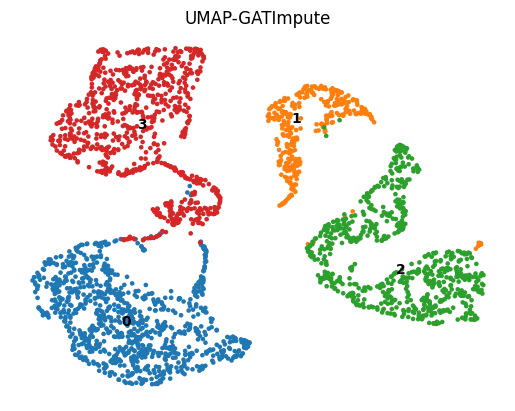

In [56]:
sc.pl.umap(adata_imp_all, color=['cluster'], legend_loc='on data', title='UMAP-GATImpute', frameon=False)

In [57]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# K-means聚类
kmeans = KMeans(n_clusters=4).fit(adata_imp_all.X)


ground_truth = adata_imp_all.obs.cluster.values
#cluster_results = adata_imp_all.obs['kmeans_clusters'].tolist()

ari = adjusted_rand_score(ground_truth, kmeans.labels_)
nmi = normalized_mutual_info_score(ground_truth, kmeans.labels_)

from sklearn.metrics import silhouette_score
# 计算轮廓系数
sil_score = silhouette_score(adata_imp_all.obsm['X_umap'],kmeans.labels_)

print("ARI: ", ari)
print("NMI: ", nmi)
print("Silhouette Score: ", sil_score)

ARI:  0.8125826147130767
NMI:  0.8240420760078531
Silhouette Score:  0.39552176
